# Gravitational Waves

This notebook provides a function which input the masses and distances of the gw sources, and produce the signal to noise ratio. Referring to Jose's notebook waveform_playground

In [21]:
import numpy as np
import bilby
#PLOTS
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [22]:
binary_parameters = dict(
        mass_1=35.,
        mass_2=30.,
        a_1= 0.,
        a_2= 0.,
        tilt_1= 0.,
        tilt_2= 0.,
        phi_12= 0.,
        phi_jl= 0.,
        luminosity_distance = 500.,
        theta_jn = np.pi/3.,
        psi = np.pi/8.,
        phase = 0.,
        geocent_time = 0.,
        ra = np.pi/4.,
        dec = 3.*np.pi/2,
    )

We first define the parameters of the binary:

- First the masses
- Then 6 parameters for the spins. Note that they are not in carteseian coordiantes. See for example https://lscsoft.docs.ligo.org/lalsuite/lalsimulation/group__lalsimulation__inference.html (I'll check for a better reference)
- Luminosity distance
- Inclination
- Polarization angle
- Phase at reference frequency
- Time of coalescence
- Right ascension
- Declination

We then specify the properties of the waveform model, in particular we use a waveform family IMRPhenom that has the possibility of including higher modes (HM) and precession (P).

For the beginning we only include the quadrupole radiation $l,m=2,2$ setting the mode array to $[2,\pm2]$

_References:_ https://arxiv.org/pdf/2004.06503.pdf

In [23]:
waveform_arguments = dict(
        waveform_approximant = 'IMRPhenomXPHM',
        reference_frequency = 50.,
        minimum_frequency = 20.,
        maximum_frequency = 2000.,
        mode_array = [[2,2],[2,-2]],
    )

In [24]:
duration = 4.0
sampling_frequency = 2048.0

waveform_generator = bilby.gw.WaveformGenerator(
        duration = duration,
        sampling_frequency = sampling_frequency,
        frequency_domain_source_model = bilby.gw.source.lal_binary_black_hole,
        parameter_conversion = bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
        waveform_arguments = waveform_arguments,
    )

11:28 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


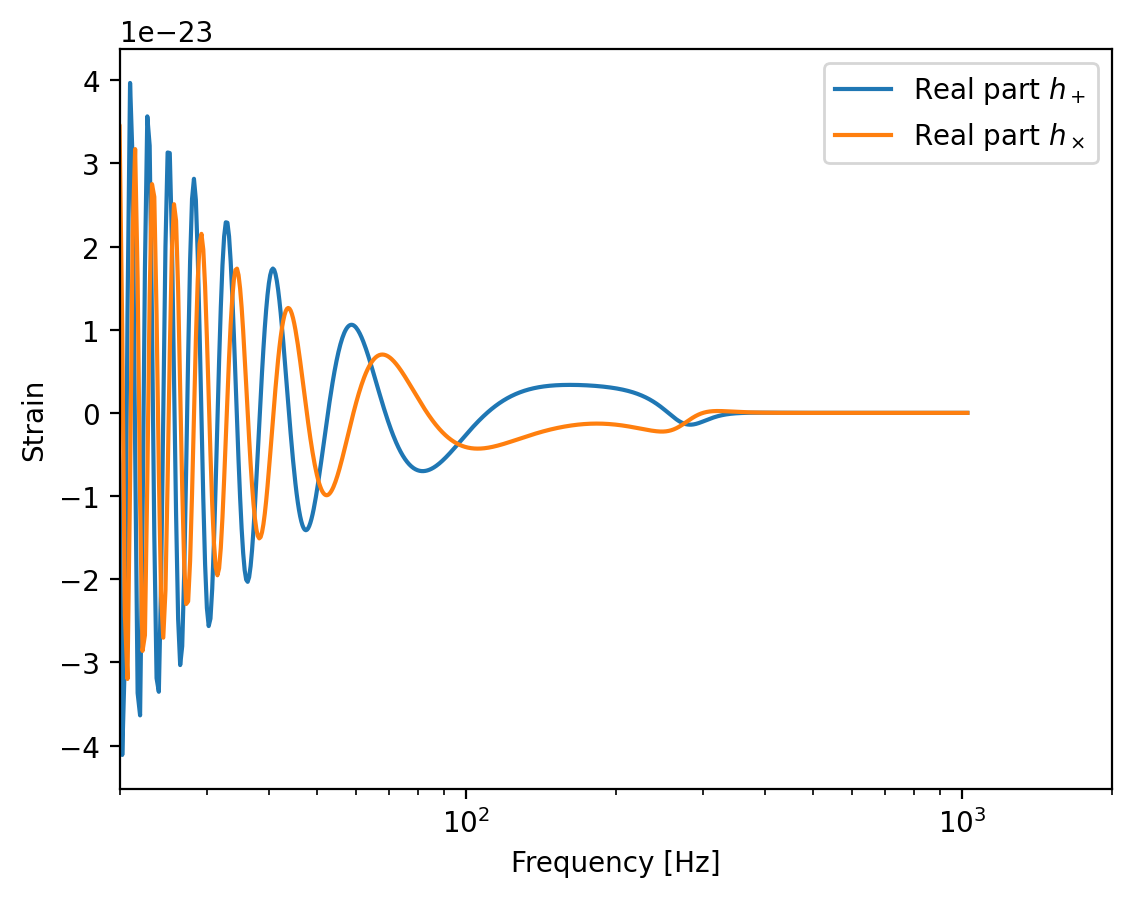

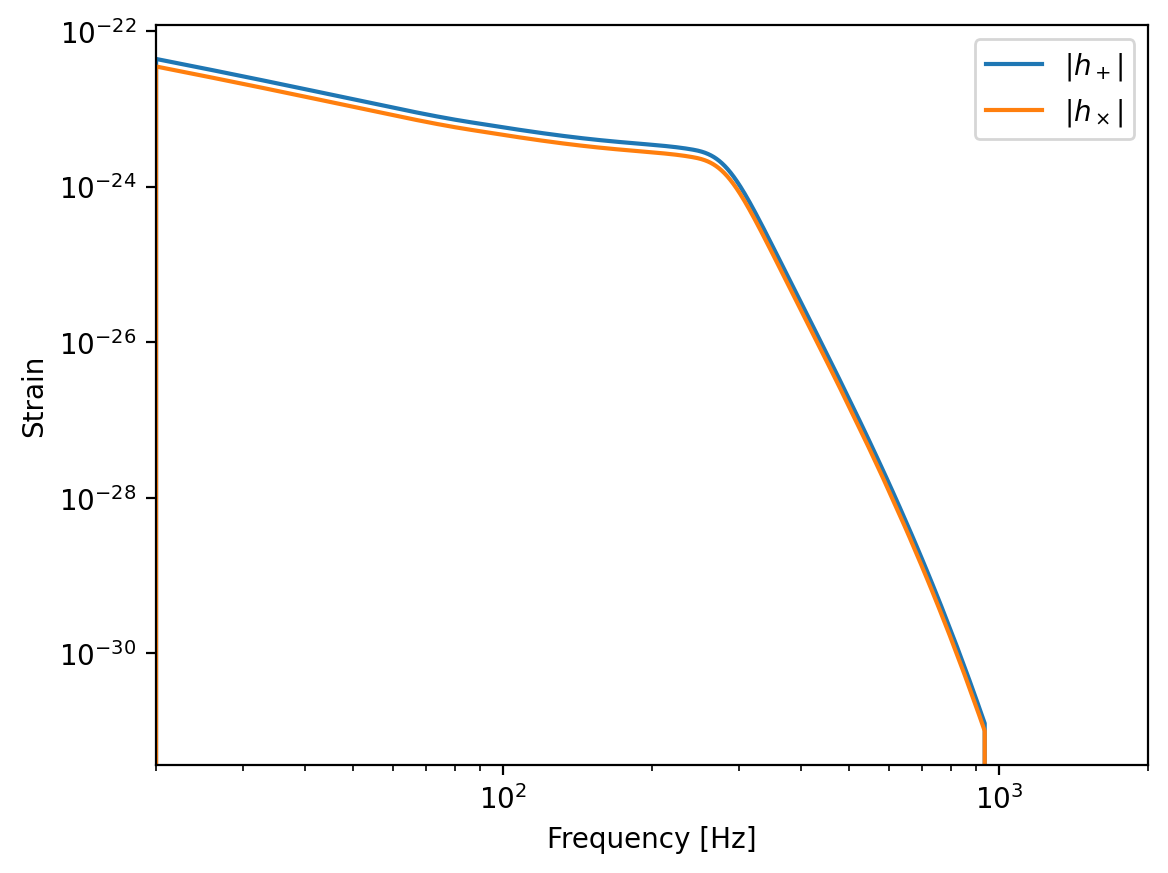

In [69]:
gen_h = waveform_generator.frequency_domain_strain(binary_parameters)
fs = bilby.core.utils.series.create_frequency_series(sampling_frequency,duration)

hp = gen_h['plus']
hx = gen_h['cross']

plt.semilogx(fs,hp,label=r'Real part $h_+$')
plt.plot(fs,hx,label=r'Real part $h_\times$')
plt.xlabel(r'Frequency [Hz]')
plt.ylabel(r'Strain')
plt.xlim([20,2e3])
plt.legend()
plt.show()

plt.loglog(fs,abs(hp),label=r'$|h_+|$')
plt.plot(fs,abs(hx),label=r'$|h_\times|$')
plt.xlabel(r'Frequency [Hz]')
plt.ylabel(r'Strain')
plt.xlim([20,2e3])
plt.legend()
plt.show()


We get the noise curves document from https://dcc.ligo.org/LIGO-T2000012-v1/public tables with frequency and Amplitude spectral density are provided and we can get power spectral density (PSD) which is the square of ASD

In [26]:
f=np.loadtxt('aligo_O4high.txt',delimiter=' ')

In [27]:
frequency,psd= f[:,0],np.square(f[:,1])

Text(0, 0.5, 'Power Spectral Density')

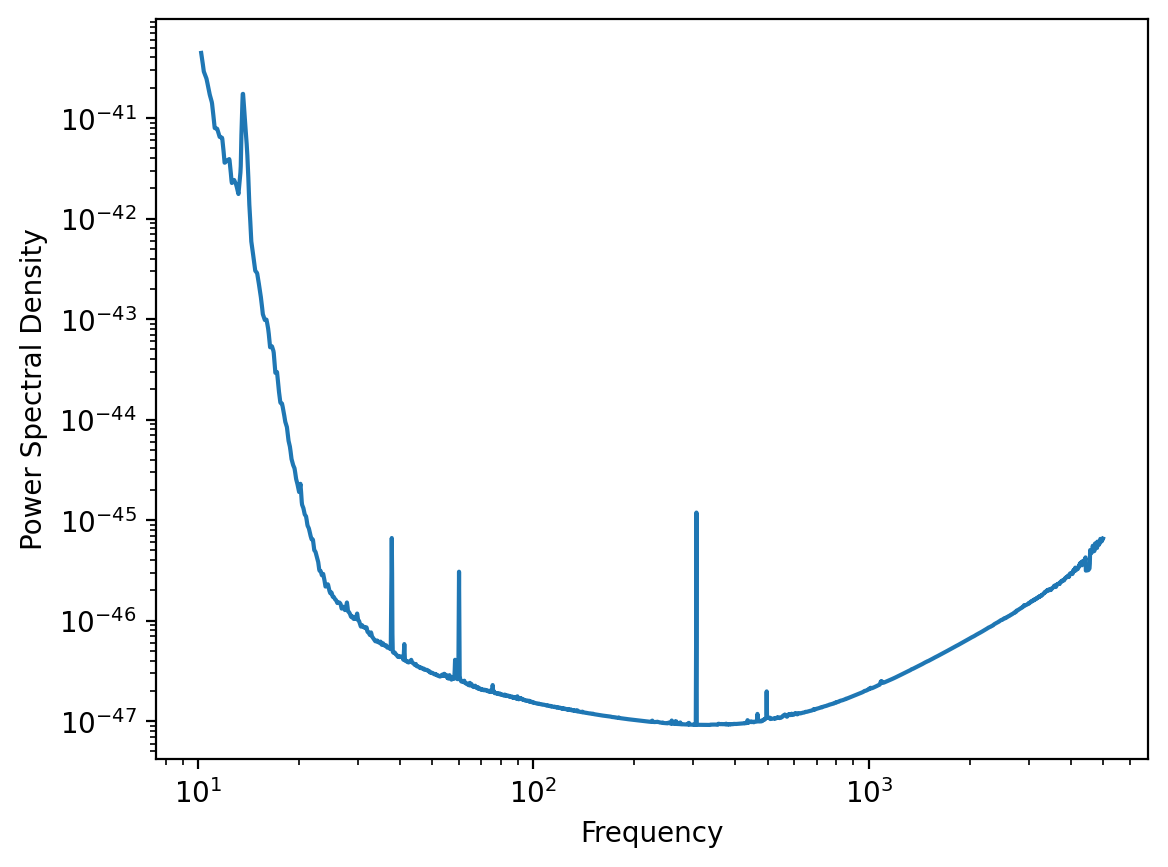

In [28]:
plt.loglog(frequency,psd)
plt.xlabel('Frequency')
plt.ylabel('Power Spectral Density')

The signal to noise ratio is defined by 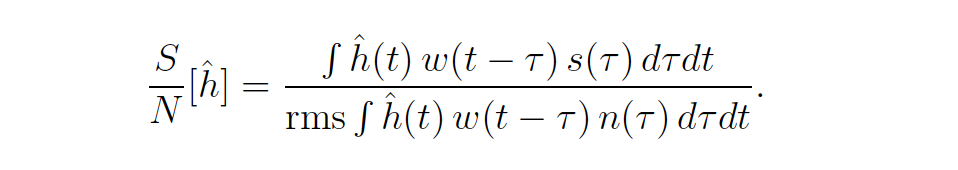 We can also use the square of singal to noise ratio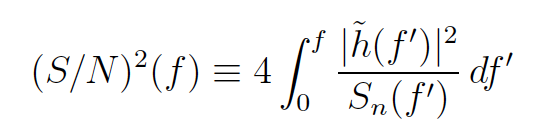

In [109]:
from scipy import constants
from scipy.interpolate import interp1d
from scipy.integrate import trapz

In [121]:
psd_extend=np.pad(psd,(0,len(fs) - len(psd)), mode='constant', constant_values=1)

sn=interp1d(fs,psd_extend)   #interpolate psd

# Define the integrand function
def integrand(fs, hp, sn):
    return (abs(hp) ** 2) / sn(fs)

# Calculate the integral using trapz
s2n = np.sqrt(4*trapz(integrand(fs, hp, sn), fs))


## SNR function using self defined mass_1 and mass_2, and distance of the objects

In [122]:
def SNR(mass1,mass2,distance,sensitivity):
    #distance should have unit of Gpc
    binary_parameters = dict(
        mass_1=mass1,
        mass_2=mass2,
        a_1= 0.,
        a_2= 0.,
        tilt_1= 0.,
        tilt_2= 0.,
        phi_12= 0.,
        phi_jl= 0.,
        luminosity_distance = distance,
        theta_jn = np.pi/10.,
        psi = np.pi/8.,
        phase = 0.,
        geocent_time = 0.,
        ra = np.pi/4,
        dec = 3.*np.pi/2,
    )
    
    
    waveform_arguments = dict(
        waveform_approximant = 'IMRPhenomXPHM',
        reference_frequency = 50.,
        minimum_frequency = 20.,
        maximum_frequency = 2000.,
        mode_array = [[2,2],[2,-2]],
    )
    duration = 4.0
    sampling_frequency = 2048.0

    waveform_generator = bilby.gw.WaveformGenerator(
        duration = duration,
        sampling_frequency = sampling_frequency,
        frequency_domain_source_model = bilby.gw.source.lal_binary_black_hole,
        parameter_conversion = bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
        waveform_arguments = waveform_arguments,
    )
    gen_h = waveform_generator.frequency_domain_strain(binary_parameters)
    fs = bilby.core.utils.series.create_frequency_series(sampling_frequency,duration)

    hp = gen_h['plus']
    hx = gen_h['cross']
    
    f=np.loadtxt(sensitivity,delimiter=' ')
    frequency,psd= f[:,0],np.square(f[:,1])
    
    psd_extend=np.pad(psd,(0,len(fs) - len(psd)), mode='constant', constant_values=1)

    sn=interp1d(fs,psd_extend)   #interpolate psd

    # Define the integrand function
    def integrand(fs, hp, sn):
        return (abs(hp) ** 2) / sn(fs)

    # Calculate the integral using trapz
    s2n = np.sqrt(4*trapz(integrand(fs, hp, sn), fs))
    
    return s2n

More modification should be made! 
Additional work, plot masses vs SNR with fixed distance and vice versa. 

In [123]:
SNR(34.,14.,3600.,'aligo_O4high.txt')

00:45 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


2.62936860070152

## Plot SNR of different masses with fixed distance

00:49 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
00:49 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
00:49 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
00:49 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
00:49 bi

00:49 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
00:49 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
00:49 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
00:49 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
00:49 bi

00:49 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
00:49 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
00:49 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
00:49 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
00:49 bi

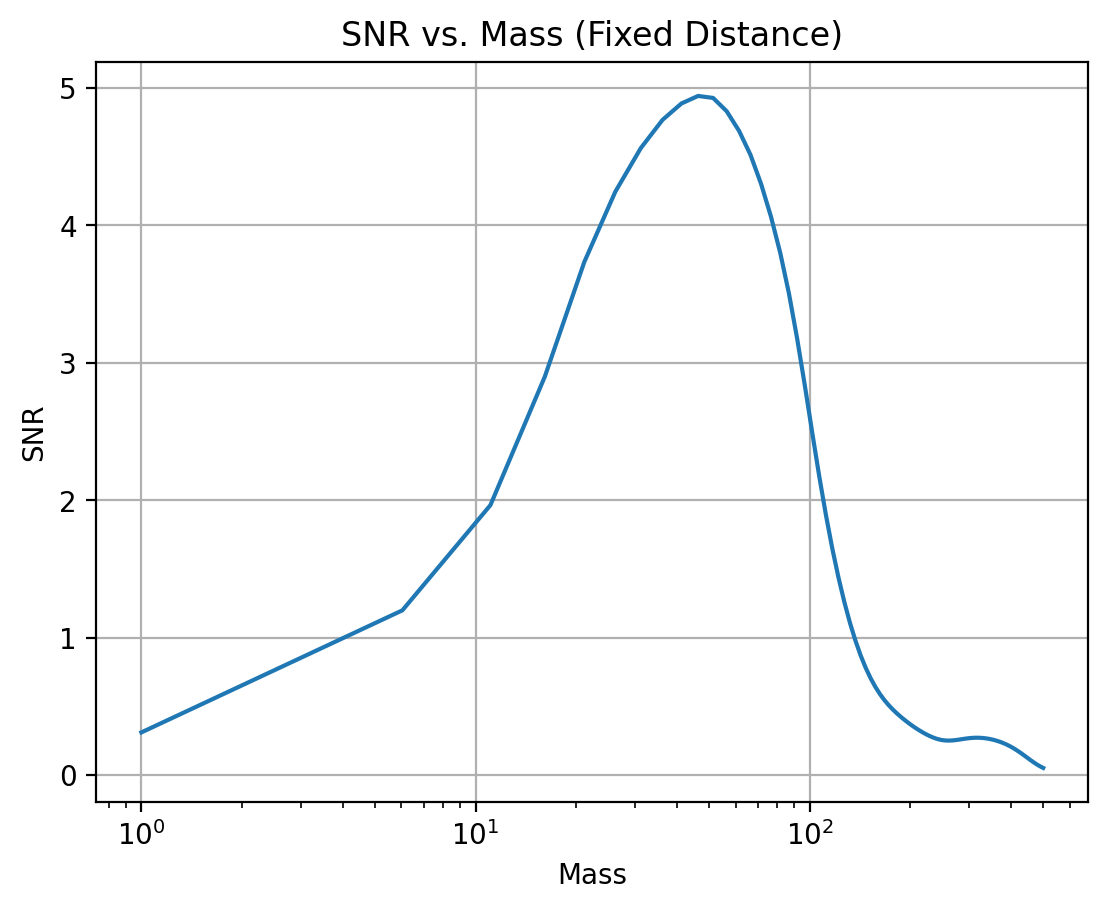

In [125]:
#list of mass values
masses=np.linspace(1,500,100)

#fixed distance value
distance=3000

#fixed sensitivity
snr_values = [SNR(mass, mass, distance, 'aligo_O4high.txt') for mass in masses]

# Plotting
#plt.plot(masses, snr_values)
plt.semilogx(masses,snr_values)
plt.xlabel('Mass')
plt.ylabel('SNR')
plt.title('SNR vs. Mass (Fixed Distance)')
plt.grid(True)
plt.show()

## PLot SNR of different distances with fixed masses

00:51 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
00:51 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
00:51 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
00:51 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
00:51 bi

00:51 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
00:51 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
00:51 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
00:51 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
00:51 bi

00:51 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
00:51 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
00:51 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
00:51 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
00:51 bi

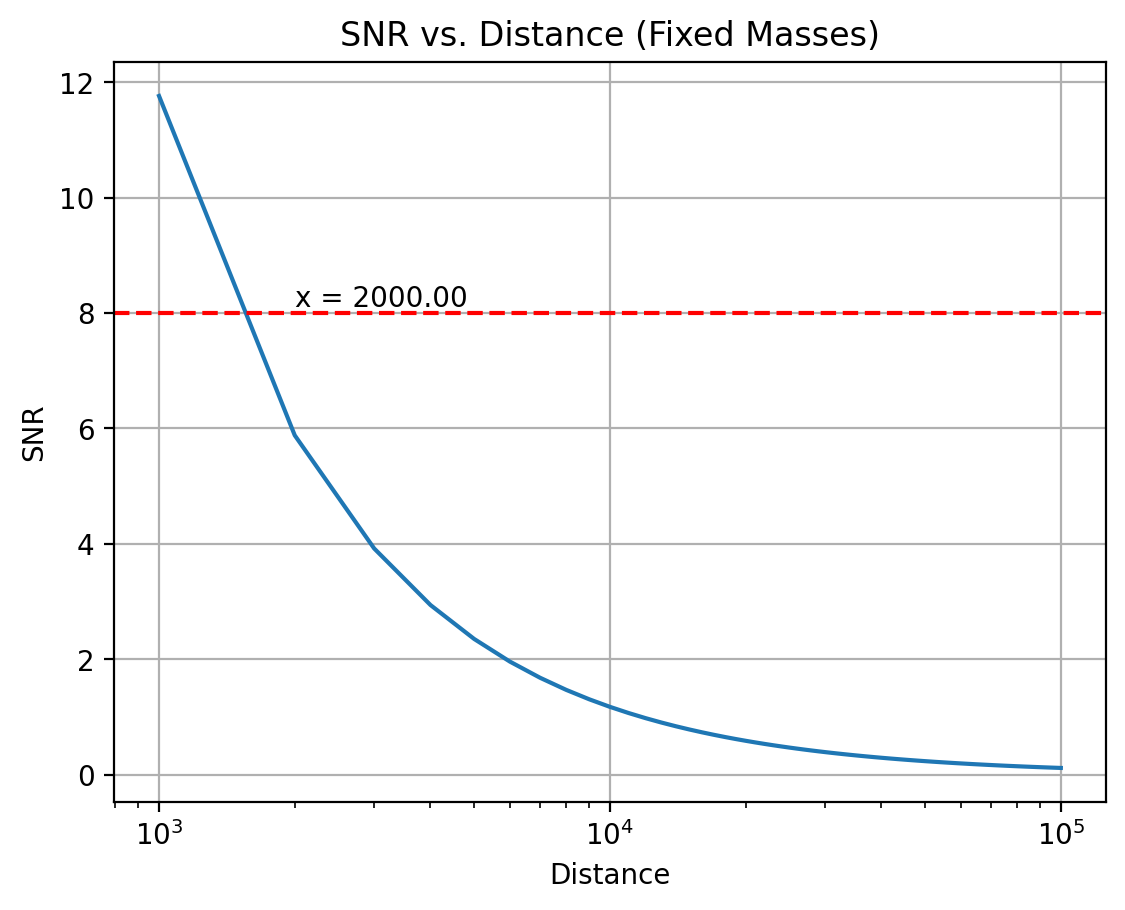

In [126]:
# Fixed masses of the sources
m1=20.
m2=30.

# Array of the distances
distances = np.linspace(1e3, 1e5,100) 

# Fixed sensitivity
sensitivity='aligo_O4high.txt'

# Calculate SNR for each distance
snr_values = [SNR(m1, m2, distance, sensitivity) for distance in distances]
# Plot the SNR values
plt.semilogx(distances, snr_values)
plt.xlabel('Distance')
plt.ylabel('SNR')
plt.title('SNR vs. Distance (Fixed Masses)')
plt.grid(True)

# Draw a horizontal line at SNR = 8
plt.axhline(y=8, color='r', linestyle='--')

# Find x value at y = 8
idx = np.argmin(np.abs(np.array(snr_values) - 8))
x_value = distances[idx]
plt.text(x_value, 8, f'x = {x_value:.2f}', ha='left', va='bottom')

plt.show()

## Apply lensing effect on gravitational waves

/Users/shangmiao/anaconda3/envs/gw_basic/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


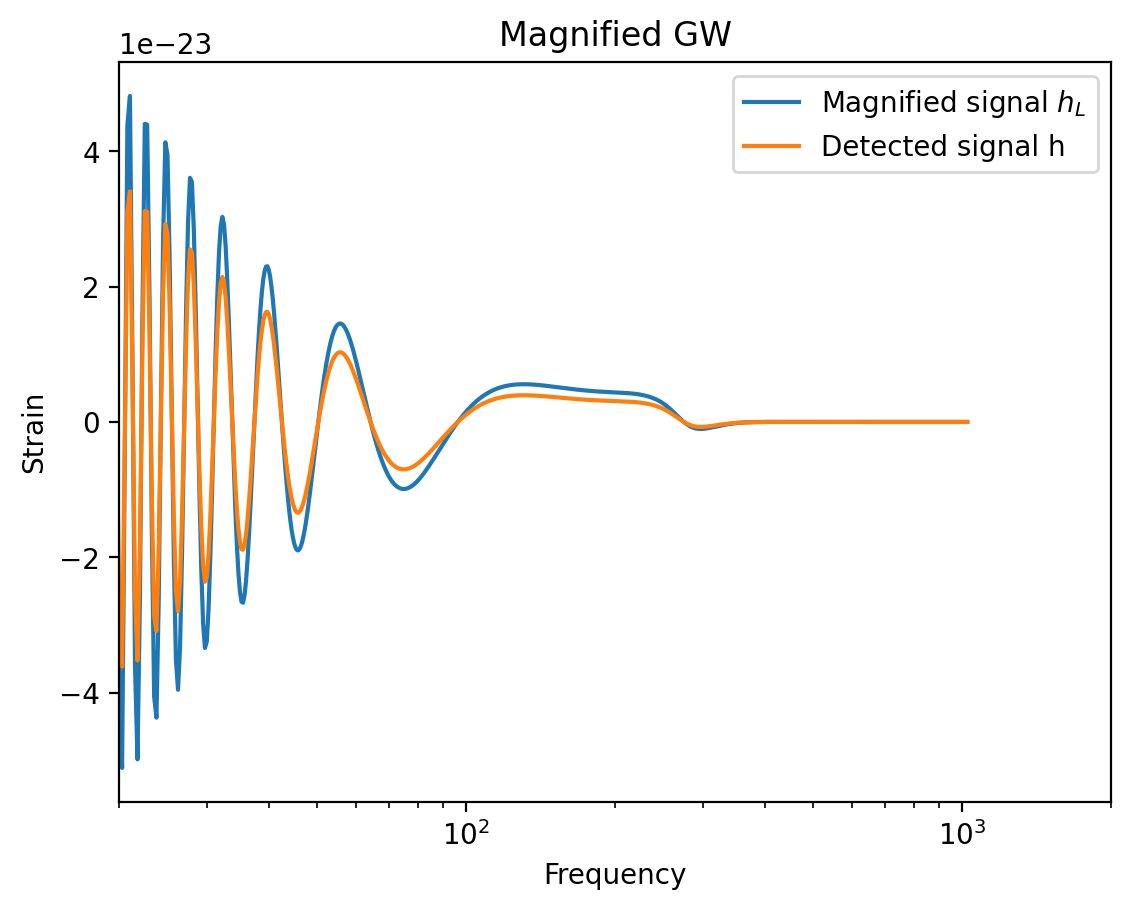

In [127]:
# Magnification
a=np.linspace(1,100,100)

# Calculate magnified signal h_l
h_l=[np.sqrt(i)*h for i in a ]

# Plot
plt.semilogx(fs,h_l[1],label=r'Magnified signal $h_L$')
plt.semilogx(fs,h,label=r'Detected signal h')
plt.xlabel('Frequency')
plt.ylabel('Strain')
plt.xlim(20,2e3)
plt.title('Magnified GW')

#plt.semilogx(fs,hp,label=r'Real part $h_+$')
#plt.semilogx(fs,hx,label=r'Real part $h_\times$')
plt.legend()
plt.show()